<h2> Importing Packages </h2>
Numpy for scientific computation <br>
Pandas for accessing the csv file with data <br>
sklearn.model_selection for selecting train, dev, test sets in a re producable way.

In [1795]:
import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import math

<h2> Preparing Train, Dev and Test Sets </h2>

In [1796]:
 ## Load Data
df = pd.read_csv('Data/financial_data2.csv')
df = df.dropna()

In [1797]:
## Splitting into X and Y
X = df.drop('Price', axis=1)
Y = df['Price']

In [1798]:
## First Split 60% for train and 40% for not train
X_train, X_not_train, Y_train, Y_not_train = train_test_split(X, Y, test_size=0.4, random_state=42)
## Second Split Allocating the 40% Remaining data equally between Test and Dev sets (20% each)
X_dev, X_test, Y_dev, Y_test = train_test_split(X_not_train, Y_not_train, test_size=0.5, random_state=42)

In [1799]:
# scaler = StandardScaler()
# scaler.fit(X_train)
# X_train = scaler.transform(X_train)
# X_dev = scaler.transform(X_dev)
# X_test = scaler.transform(X_test)

<h2> Helper Function Development <h2>

In [1800]:
def sigmoid(z): ## Sigmoid Function
    return 1/(1+np.exp(-z))

In [1801]:
def relu(x): ## ReLU (Rectified Linear Unit) Function
    return np.maximum(0, x)

In [1802]:
def initialize_parameters(n_x, n_h1, n_h2, n_y): ## Inititalize the "W" Parameters to avoid the resulting linear function if all the same originally
    np.random.seed(1)
    W1 = np.random.randn(n_h1, n_x) * 0.01
    b1 = np.zeros((n_h1, 1))
    W2 = np.random.randn(n_h2, n_h1) * 0.01
    b2 = np.zeros((n_h2, 1))
    W3 = np.random.randn(n_y, n_h2) * 0.01
    b3 = np.zeros((n_y, 1))

    parameters = {"W1": W1, "b1": b1,
                  "W2": W2, "b2": b2,
                  "W3": W3, "b3": b3}

    return parameters

In [1803]:
def forward_propagation(X, parameters):
    W1 = parameters["W1"]
    b1 = parameters["b1"]
    W2 = parameters["W2"]
    b2 = parameters["b2"]
    W3 = parameters["W3"]
    b3 = parameters["b3"]

    Z1 = np.dot(W1, X) + b1
    A1 = relu(Z1)
    Z2 = np.dot(W2, A1) + b2
    A2 = relu(Z2)
    Z3 = np.dot(W3, A2) + b3
    A3 = Z3  # No activation for the last layer

    cache = (Z1, A1, W1, b1, Z2, A2, W2, b2, Z3, A3, W3, b3)

    return A3, cache

In [1804]:
def compute_cost(A3, Y): # Mean Squared Error
    m = Y.shape[1]
    cost = (1 / (2 * m)) * np.sum(np.square(A3 - Y)) 
    return cost

In [1805]:
def backward_propagation(X, Y, cache):
    m = X.shape[1]
    (Z1, A1, W1, b1, Z2, A2, W2, b2, Z3, A3, W3, b3) = cache

    dZ3 = A3 - Y
    dW3 = 1./m * np.dot(dZ3, A2.T)
    db3 = 1./m * np.sum(dZ3, axis=1, keepdims = True)

    dA2 = np.dot(W3.T, dZ3)
    dZ2 = np.multiply(dA2, np.int64(A2 > 0))
    dW2 = 1./m * np.dot(dZ2, A1.T)
    db2 = 1./m * np.sum(dZ2, axis=1, keepdims = True)

    dA1 = np.dot(W2.T, dZ2)
    dZ1 = np.multiply(dA1, np.int64(A1 > 0))
    dW1 = 1./m * np.dot(dZ1, X.T)
    db1 = 1./m * np.sum(dZ1, axis=1, keepdims = True)

    gradients = {"dZ3": dZ3, "dW3": dW3, "db3": db3,
                 "dA2": dA2, "dZ2": dZ2, "dW2": dW2, "db2": db2,
                 "dA1": dA1, "dZ1": dZ1, "dW1": dW1, "db1": db1}

    return gradients

In [1806]:
def update_parameters(parameters, grads, learning_rate):
    parameters["W1"] = parameters["W1"] - learning_rate * grads["dW1"]
    parameters["b1"] = parameters["b1"] - learning_rate * grads["db1"]
    parameters["W2"] = parameters["W2"] - learning_rate * grads["dW2"]
    parameters["b2"] = parameters["b2"] - learning_rate * grads["db2"]
    parameters["W3"] = parameters["W3"] - learning_rate * grads["dW3"]
    parameters["b3"] = parameters["b3"] - learning_rate * grads["db3"]

    return parameters

In [1807]:
def initialize_adam(parameters) :
    
    L = len(parameters) // 2 # number of layers in the neural networks
    v = {}
    s = {}
    
    # Initialize v, s. Input: "parameters". Outputs: "v, s".
    for l in range(1, L + 1):
        v["dW" + str(l)] = np.zeros_like(parameters["W" + str(l)])
        v["db" + str(l)] = np.zeros_like(parameters["b" + str(l)])
        s["dW" + str(l)] = np.zeros_like(parameters["W" + str(l)])
        s["db" + str(l)] = np.zeros_like(parameters["b" + str(l)])
    
    return v, s

In [1808]:
def update_parameters_with_adam(parameters, grads, v, s, t, learning_rate = 0.01,
                                beta1 = 0.9, beta2 = 0.999,  epsilon = 1e-8):
    L = len(parameters) // 2
    v_corrected = {}                         # Initializing first moment estimate, python dictionary
    s_corrected = {}                         # Initializing second moment estimate, python dictionary
    
    # Perform Adam update on all parameters
    for l in range(1, L + 1):
        # Moving average of the gradients. Inputs: "v, grads, beta1". Output: "v".
        v["dW" + str(l)] = beta1 * v["dW" + str(l)] + (1 - beta1) * grads['dW' + str(l)]
        v["db" + str(l)] = beta1 * v["db" + str(l)] + (1 - beta1) * grads['db' + str(l)]

        # Compute bias-corrected first moment estimate. Inputs: "v, beta1, t". Output: "v_corrected".
        v_corrected["dW" + str(l)] = v["dW" + str(l)] / (1 - np.power(beta1, t))
        v_corrected["db" + str(l)] = v["db" + str(l)] / (1 - np.power(beta1, t))

        # Moving average of the squared gradients. Inputs: "s, grads, beta2". Output: "s".
        s["dW" + str(l)] = beta2 * s["dW" + str(l)] + (1 - beta2) * np.power(grads['dW' + str(l)], 2)
        s["db" + str(l)] = beta2 * s["db" + str(l)] + (1 - beta2) * np.power(grads['db' + str(l)], 2)

        # Compute bias-corrected second raw moment estimate. Inputs: "s, beta2, t". Output: "s_corrected".
        s_corrected["dW" + str(l)] = s["dW" + str(l)] / (1 - np.power(beta2, t))
        s_corrected["db" + str(l)] = s["db" + str(l)] / (1 - np.power(beta2, t))

        # Update parameters. Inputs: "parameters, learning_rate, v_corrected, s_corrected, epsilon". Output: "parameters".
        parameters["W" + str(l)] = parameters["W" + str(l)] - learning_rate * v_corrected["dW" + str(l)] / (np.sqrt(s_corrected["dW" + str(l)]) + epsilon)
        parameters["b" + str(l)] = parameters["b" + str(l)] - learning_rate * v_corrected["db" + str(l)] / (np.sqrt(s_corrected["db" + str(l)]) + epsilon)

    return parameters, v, s, v_corrected, s_corrected

In [1809]:
def random_mini_batches(X, Y, mini_batch_size=2048, seed=0):
    
    np.random.seed(seed)            # To make your "random" minibatches the same as ours
    m = X.shape[1]                  # number of training examples
    mini_batches = []

    permutation = list(np.random.permutation(m))
    shuffled_X = X[:, permutation]
    shuffled_Y = Y[:, permutation].reshape((1, m))

    num_complete_minibatches = math.floor(m / mini_batch_size) # number of mini batches of size mini_batch_size in your partitionning
    for k in range(0, num_complete_minibatches):
        mini_batch_X = shuffled_X[:, k * mini_batch_size : (k+1) * mini_batch_size]
        mini_batch_Y = shuffled_Y[:, k * mini_batch_size : (k+1) * mini_batch_size]

        mini_batch = (mini_batch_X, mini_batch_Y)
        mini_batches.append(mini_batch)

    # For handling the end case (last mini-batch < mini_batch_size i.e less than 64)
    if m % mini_batch_size != 0:
        mini_batch_X = shuffled_X[:, num_complete_minibatches * mini_batch_size :]
        mini_batch_Y = shuffled_Y[:, num_complete_minibatches * mini_batch_size :]

        mini_batch = (mini_batch_X, mini_batch_Y)
        mini_batches.append(mini_batch)

    return mini_batches

In [1810]:
def update_lr(learning_rate0, epoch_num, decay_rate):
    learning_rate = (1/(1+(decay_rate*epoch_num)))*learning_rate0
    return learning_rate

In [1811]:
def schedule_lr_decay(learning_rate0, epoch_num, decay_rate, time_interval=1000):
    learning_rate = (1/(1+decay_rate*np.floor(epoch_num/time_interval)))*learning_rate0
    return learning_rate

In [1812]:
def model1(X, Y, learning_rate = 0.000001, num_iterations = 900001): ## Without Adam and Batch Gradient Descent
    grads = {}
    costs = [] 
    m = X.shape[1] 
    layers_dims = [X.shape[0], 20, 7, 1]

    parameters = initialize_parameters(layers_dims[0], layers_dims[1], layers_dims[2], layers_dims[3])

    for i in range(0, num_iterations):
        A3, cache = forward_propagation(X, parameters)
        cost = compute_cost(A3, Y)
        grads = backward_propagation(X, Y, cache)
        parameters = update_parameters(parameters, grads, learning_rate)

        if i % 100 == 0:
            if i % 1000 == 0:
                print("Cost after iteration Model1 {}: {}".format(i, cost))
            costs.append(cost)

    plt.plot(costs)
    plt.ylabel('cost')
    plt.xlabel('iterations (per thousands)')
    plt.title("Learning rate = " + str(learning_rate))
    plt.show()
    
    return parameters

In [1813]:
def model2(X, Y, learning_rate = 0.00001, num_iterations = 900001, beta1 = 0.9, beta2 = 0.999,  epsilon = 1e-8): ## With Adam Single Batch Gradient Decent
    grads = {}
    costs = [] 
    m = X.shape[1] 
    layers_dims = [X.shape[0], 20, 7, 1]

    parameters = initialize_parameters(layers_dims[0], layers_dims[1], layers_dims[2], layers_dims[3])
    
    # Initialize v and s for Adam optimizer
    v, s = initialize_adam(parameters)
    t = 0

    for i in range(num_iterations):
        # Forward propagation
        A3, cache = forward_propagation(X, parameters)

        # Compute cost
        cost = compute_cost(A3, Y)

        # Backward propagation
        grads = backward_propagation(X, Y, cache)

        # Update parameters using Adam optimization
        t = t + 1 # Increment the timestep 't'
        parameters, v, s, v_corrected, s_corrected = update_parameters_with_adam(parameters, grads, v, s, t, learning_rate, beta1, beta2, epsilon)

        # Print the cost every 1000 iterations
        if i % 100 == 0:
            if i % 1000 == 0:
                print("Cost after iteration Model2 {}: {}".format(i, cost))
            costs.append(cost)
            
    plt.plot(costs)
    plt.ylabel('cost')
    plt.xlabel('iterations (per thousands)')
    plt.title("Learning rate = " + str(learning_rate))
    plt.show()  
    
    return parameters

In [1814]:
def model3(X, Y, learning_rate = 0.000001, num_iterations = 900001, mini_batch_size = 2048, beta1 = 0.9, beta2 = 0.999,  epsilon = 1e-8): ## Mini Batch With Adam Opimizer
    grads = {}
    costs = [] 
    m = X.shape[1] 
    layers_dims = [X.shape[0], 20, 7, 1]

    parameters = initialize_parameters(layers_dims[0], layers_dims[1], layers_dims[2], layers_dims[3])
    # Initialize v and s for Adam optimizer
    v, s = initialize_adam(parameters)
    t = 0
    for i in range(num_iterations):
        # Create mini-batches
        minibatches = random_mini_batches(X, Y, mini_batch_size, seed = i)

        for minibatch in minibatches:
            # Select a minibatch
            (minibatch_X, minibatch_Y) = minibatch

            # Forward propagation
            A3, cache = forward_propagation(minibatch_X, parameters)

            # Compute cost
            cost = compute_cost(A3, minibatch_Y)

            # Backward propagation
            grads = backward_propagation(minibatch_X, minibatch_Y, cache)

            # Update parameters using Adam optimization
            t = t + 1 # Increment the timestep 't'
            parameters, v, s, v_corrected, s_corrected = update_parameters_with_adam(parameters, grads, v, s, t, learning_rate, beta1, beta2, epsilon)

        # Print the cost every 1000 iterations
        if i % 100 == 0:
            if i % 1000 == 0:
                print("Cost after iteration Model3 {}: {}".format(i, cost))
            costs.append(cost)
    
    plt.plot(costs)
    plt.ylabel('cost')
    plt.xlabel('iterations (per thousands)')
    plt.title("Learning rate = " + str(learning_rate))
    plt.show() 
    
    return parameters


In [1815]:
def model4(X, Y, learning_rate0 = 0.00001, num_iterations = 900001, mini_batch_size = 2048, decay_rate = 0.001, time_interval=1000, beta1 = 0.9, beta2 = 0.999, epsilon = 1e-8): ## Mini Batch With Adam Opimizer and Learning Rate Decay
    grads = {}
    costs = [] 
    m = X.shape[1] 
    layers_dims = [X.shape[0], 20, 7, 1]

    parameters = initialize_parameters(layers_dims[0], layers_dims[1], layers_dims[2], layers_dims[3])
    # Initialize v and s for Adam optimizer
    v, s = initialize_adam(parameters)
    t = 0
    for i in range(num_iterations):
        # Create mini-batches
        minibatches = random_mini_batches(X, Y, mini_batch_size, seed = i)

        learning_rate = update_lr(learning_rate0, i, decay_rate) # update learning rate using exponential decay
        
        for minibatch in minibatches:
            # Select a minibatch
            (minibatch_X, minibatch_Y) = minibatch

            # Forward propagation
            A3, cache = forward_propagation(minibatch_X, parameters)

            # Compute cost
            cost = compute_cost(A3, minibatch_Y)

            # Backward propagation
            grads = backward_propagation(minibatch_X, minibatch_Y, cache)

            # Update parameters using Adam optimization
            t = t + 1 # Increment the timestep 't'
            parameters, v, s, v_corrected, s_corrected = update_parameters_with_adam(parameters, grads, v, s, t, learning_rate, beta1, beta2, epsilon)

        # Update the learning rate every time_interval epochs
        if i % time_interval == 0:
            learning_rate = schedule_lr_decay(learning_rate0, i, decay_rate, time_interval)

        # Print the cost every 1000 iterations
        if i % 100 == 0:
            if i % 1000 == 0:
                print("Cost after iteration Model4 {}: {}".format(i, cost))
            costs.append(cost)
            
    plt.plot(costs)
    plt.ylabel('cost')
    plt.xlabel('iterations (per thousands)')
    plt.title("Learning rate = " + str(learning_rate0))
    plt.show()   
    
    return parameters


In [1816]:
X_train = X_train.values.T
# X_train = X_train.T
Y_train = Y_train.values.reshape(1, -1)

# Run the model
# parameters1 = model1(X_train, Y_train)
# parameters2 = model2(X_train, Y_train)
# parameters3 = model3(X_train, Y_train)
# parameters4 = model4(X_train, Y_train)

Cost after iteration Model1 0: 14982.259308541494


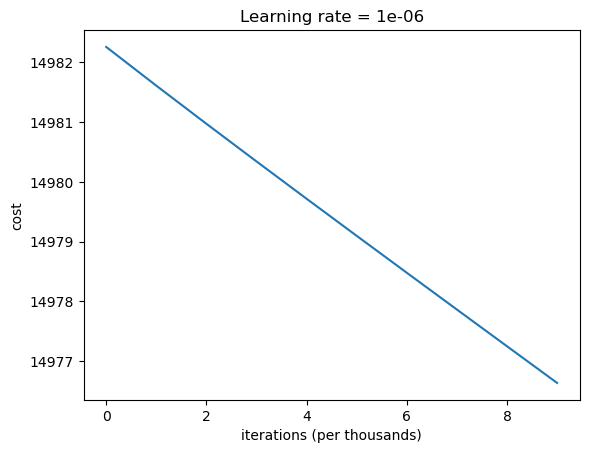

In [1817]:
parameters1 = model1(X_train, Y_train)

Cost after iteration Model2 0: 14982.259308541494


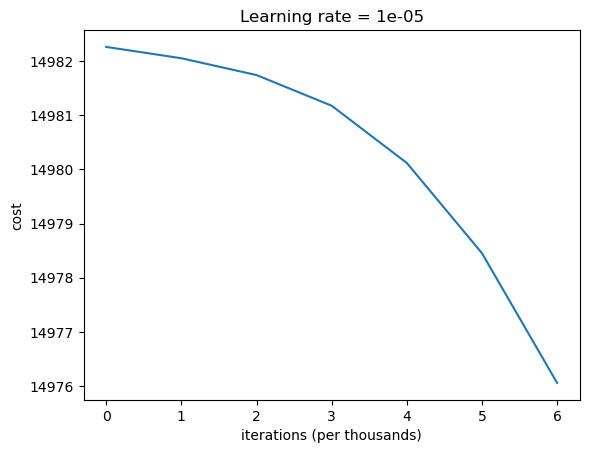

In [1818]:
parameters2 = model2(X_train, Y_train)

Cost after iteration Model3 0: 21303.55342249636


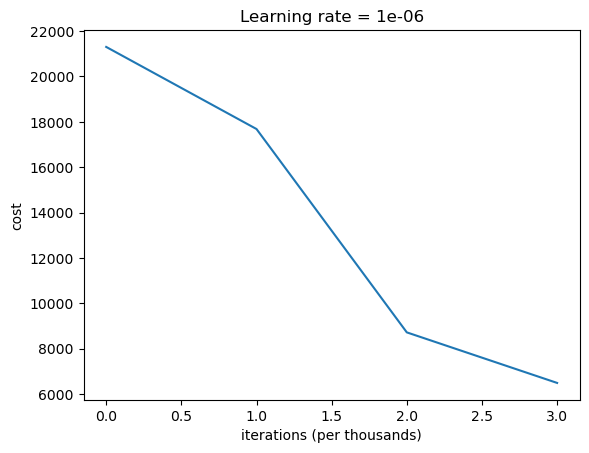

In [1819]:
parameters3 = model3(X_train, Y_train)

Cost after iteration Model4 0: 21303.532605754644


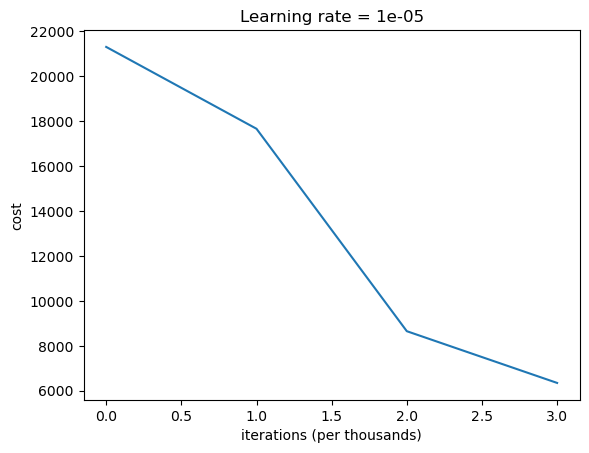

In [1820]:
parameters4 = model4(X_train, Y_train)

In [1821]:
def predict(X, parameters):
    A3, cache = forward_propagation(X, parameters)
    
    return A3

In [1822]:
# X_dev = X_dev.values.T
Y_dev = Y_dev.values.reshape(1, -1)
X_dev = X_dev.T

In [1830]:
predictions_dev1 = predict(X_dev, parameters1)
predictions_dev2 = predict(X_dev, parameters2)
predictions_dev3 = predict(X_dev, parameters3)
predictions_dev4 = predict(X_dev, parameters4)

In [1831]:
dev_cost1 = compute_cost(predictions_dev1, Y_dev)
print("Cost on dev set Model1: {}".format(dev_cost1))

dev_cost2 = compute_cost(predictions_dev2, Y_dev)
print("Cost on dev set Model2: {}".format(dev_cost2))

dev_cost3 = compute_cost(predictions_dev3, Y_dev)
print("Cost on dev set Model3: {}".format(dev_cost3))

dev_cost4 = compute_cost(predictions_dev4, Y_dev)
print("Cost on dev set Model4: {}".format(dev_cost4))

Cost on dev set Model1: 12881.76047726974
Cost on dev set Model2: 12882.229952232825
Cost on dev set Model3: 12886.52813712158
Cost on dev set Model4: 12618.545392940963


In [1825]:
# for i in range(len(predictions_dev[0])):
#     print("Predicted: " + str(predictions_dev1[0][i]) + " Actual: " + str(Y_dev.T[i]))

Predicted: 0.07018475425959884 Actual: [79.87]
Predicted: 0.07019080093963449 Actual: [36.84]
Predicted: 0.07019824743555471 Actual: [16.58]
Predicted: 0.07018681652243074 Actual: [67.95]
Predicted: 0.07020020741611252 Actual: [182.11]
Predicted: 0.07019140767527524 Actual: [54.12]
Predicted: 0.07020368071336253 Actual: [16.5]
Predicted: 0.07019773385130203 Actual: [46.24]
Predicted: 0.07035636520731915 Actual: [45.23]
Predicted: 0.07019793099973368 Actual: [32.91]
Predicted: 0.07014171348986172 Actual: [156.08]
Predicted: 0.07019280278740812 Actual: [44.58]
Predicted: 0.07028187722741079 Actual: [69.34]
Predicted: 0.07023771837714839 Actual: [160.72]
Predicted: 0.07017164476045605 Actual: [115.68]
Predicted: 0.07018783213968732 Actual: [26.85]
Predicted: 0.07019511386183241 Actual: [13.38]
Predicted: 0.070218038999358 Actual: [39.69]
Predicted: 0.07026980519017087 Actual: [47.24]
Predicted: 0.0702380147313905 Actual: [52.83]
Predicted: 0.07019704449738952 Actual: [60.82]
Predicted: 0.

Predicted: 0.07021311998643263 Actual: [64.31]
Predicted: 0.0701846531820111 Actual: [10.24]
Predicted: 0.07013696054187389 Actual: [148.14]
Predicted: 0.07020149408022336 Actual: [25.24]
Predicted: 0.07016036914549993 Actual: [199.41]
Predicted: 0.0702625115235005 Actual: [23.94]
Predicted: 0.07021196178708125 Actual: [27.27]
Predicted: 0.07025593834737803 Actual: [45.36]
Predicted: 0.07023433307364371 Actual: [23.65]
Predicted: 0.07019347526977118 Actual: [9.5]
Predicted: 0.07017411920381049 Actual: [103.87]
Predicted: 0.07022366788593659 Actual: [65.92]
Predicted: 0.07018990636440446 Actual: [54.]
Predicted: 0.07023558678621741 Actual: [68.16]
Predicted: 0.07019529119042331 Actual: [33.34]
Predicted: 0.07019444958975175 Actual: [15.69]
Predicted: 0.07019010381729263 Actual: [16.67]
Predicted: 0.07019765835873425 Actual: [23.61]
Predicted: 0.07019767901926702 Actual: [18.83]
Predicted: 0.0702006976587871 Actual: [7.17]
Predicted: 0.070182352563192 Actual: [59.54]
Predicted: 0.0702528

Predicted: 0.0702351984483478 Actual: [47.29]
Predicted: 0.07020903604530926 Actual: [47.13]
Predicted: 0.07019745642374745 Actual: [68.41]
Predicted: 0.07028930585177767 Actual: [37.87]
Predicted: 0.07023054002392151 Actual: [466.74]
Predicted: 0.07020980603626162 Actual: [60.22]
Predicted: 0.07019831127382979 Actual: [15.52]
Predicted: 0.0701860527585395 Actual: [48.79]
Predicted: 0.07016251699912074 Actual: [412.16]
Predicted: 0.07021757171815189 Actual: [5.89]
Predicted: 0.07018067624917661 Actual: [56.45]
Predicted: 0.07023588774449532 Actual: [620.39]
Predicted: 0.07030502821508597 Actual: [10.76]
Predicted: 0.07018934277299131 Actual: [162.02]
Predicted: 0.07022252726264039 Actual: [24.69]
Predicted: 0.07020148448673441 Actual: [27.9]
Predicted: 0.07021774879041803 Actual: [53.29]
Predicted: 0.07026648918271228 Actual: [66.61]
Predicted: 0.07027367377365373 Actual: [196.59]
Predicted: 0.07028326000326311 Actual: [335.82]
Predicted: 0.07019922866374605 Actual: [54.38]
Predicted: 

In [1826]:
# X_test = X_test.values.T
# Y_test = Y_test.values.reshape(1, -1)

In [1827]:
# predictions_test = predict(X_test, parameters)

In [1828]:
# test_cost = compute_cost(predictions_test, Y_test)
# print("Cost on test set: {}".format(test_cost))

In [1829]:
# for i in range(len(predictions_test[0])):
#     print("Predicted: " + str(predictions_test[0][i]) + " Actual: " + str(Y_test.T[i]))